In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf

2023-06-22 21:35:27.270343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
from PIL import Image
import numpy as np
import torch

data_loc = 'cadataset'
classes_types = ['0', '1']

data = []
labels = []

for label in classes_types:
    path = os.path.join(data_loc, label)
    clas = classes_types.index(label)
    
    for img_file in os.listdir(path):
        try:
            img = Image.open(os.path.join(path, img_file))
            img = img.resize((50, 50), resample=Image.BILINEAR)
            img = np.array(img)
            img = torch.from_numpy(img).permute(2, 0, 1)
            
            
            data.append(img)
            labels.append(clas)
            
        except:
            pass

data = torch.stack(data)
labels = torch.tensor(labels)

data = data.transpose(1, 2).transpose(2, 3)


if labels.ndim > 1:
    labels = np.squeeze(labels, axis=1)

print(f"Shape of Data is: {data.shape}")
print(f"Shape of Labels is: {labels.shape}")


Shape of Data is: torch.Size([277524, 50, 50, 3])
Shape of Labels is: torch.Size([277524])


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.3)

print("Shape of training data is:", X_train.shape)
print("Shape of testing data is:", X_test.shape)

X_train=X_train.numpy().astype(np.uint8)
X_test=X_test.numpy().astype(np.uint8)
Y_train=Y_train.numpy().astype(np.uint8)
Y_test=Y_test.numpy().astype(np.uint8)

X_train=tf.convert_to_tensor(X_train)
X_test=tf.convert_to_tensor(X_test)
Y_train=tf.convert_to_tensor(Y_train)
Y_test=tf.convert_to_tensor(Y_test)


Shape of training data is: torch.Size([194266, 50, 50, 3])
Shape of testing data is: torch.Size([83258, 50, 50, 3])


2023-06-22 21:37:35.874688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


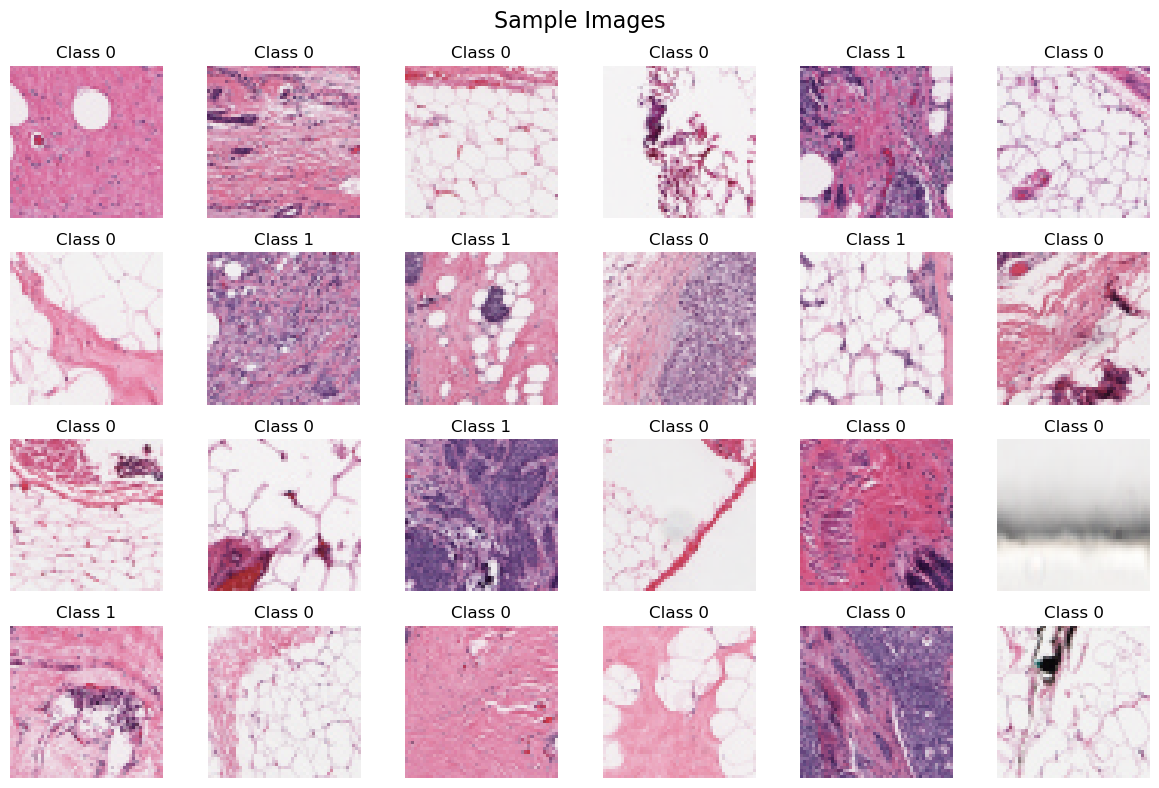

In [4]:
class_labels = ['Class 0', 'Class 1']

num_rows = 4
num_cols = 6

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
fig.suptitle("Sample Images", fontsize=16)

axes = axes.flatten()

random_indices = np.random.choice(len(X_train), size=num_rows*num_cols, replace=False)

for i, idx in enumerate(random_indices):
    image = X_train[idx]
    label = class_labels[Y_train[idx]]
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(label)

plt.tight_layout()
plt.show()

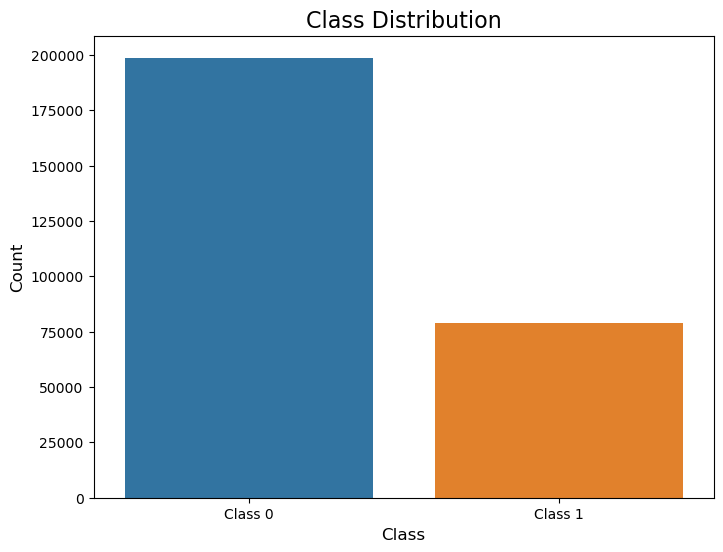

In [5]:
class_counts = np.bincount(labels)
class_labels = ['Class 0', 'Class 1']

plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels, y=class_counts)
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


In [6]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools


In [7]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=4)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))


In [8]:
model.compile(Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])


In [9]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                        

In [10]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 20, batch_size = 42)


Epoch 1/20
4626/4626 [==============================] - 1158s 250ms/step - loss: 0.3648 - accuracy: 0.8421 - val_loss: 0.3547 - val_accuracy: 0.8433
Epoch 2/20
4626/4626 [==============================] - 1218s 263ms/step - loss: 0.3232 - accuracy: 0.8635 - val_loss: 0.3977 - val_accuracy: 0.8259
Epoch 3/20
4626/4626 [==============================] - 1251s 270ms/step - loss: 0.3067 - accuracy: 0.8706 - val_loss: 0.8714 - val_accuracy: 0.6541
Epoch 4/20
4626/4626 [==============================] - 1205s 260ms/step - loss: 0.2954 - accuracy: 0.8753 - val_loss: 0.3238 - val_accuracy: 0.8663
Epoch 5/20
4626/4626 [==============================] - 1291s 279ms/step - loss: 0.2860 - accuracy: 0.8796 - val_loss: 0.3290 - val_accuracy: 0.8635
Epoch 6/20
4626/4626 [==============================] - 1409s 305ms/step - loss: 0.2776 - accuracy: 0.8829 - val_loss: 0.4303 - val_accuracy: 0.8153
Epoch 7/20
4626/4626 [==============================] - 1400s 303ms/step - loss: 0.2721 - accuracy: 0.8852

In [10]:
model.save('breast_cancer_model.h5')

8673/8673 [==============================] - 493s 57ms/step


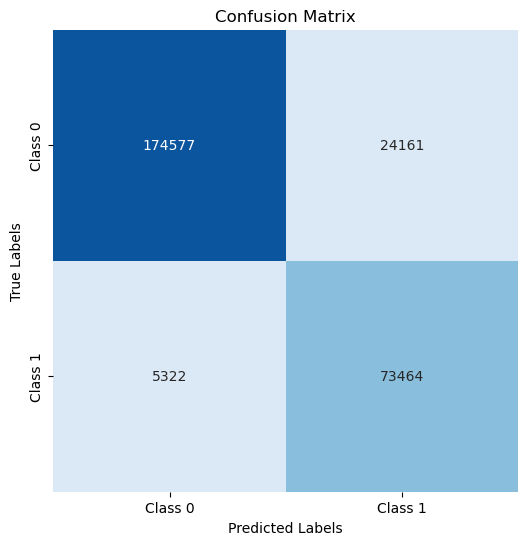

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import keras

model = keras.models.load_model('breast_cancer_model.h5')


y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()


cm = confusion_matrix(Y_test, y_pred)


labels = ['Class 0', 'Class 1']


cmap = sns.color_palette("Blues")


plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=labels, yticklabels=labels)


plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


In [6]:
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

data_loc = 'cadataset'
classes_types = ['0', '1']

data = []
labels = []

for label in classes_types:
    path = os.path.join(data_loc, label)
    clas = classes_types.index(label)
    
    for img_file in os.listdir(path):
        try:
            img = Image.open(os.path.join(path, img_file))
            img = img.resize((50, 50), resample=Image.BILINEAR)
            img = np.array(img)
            
            img_flat = img.flatten()
            
            data.append(img_flat)
            labels.append(clas)
            
        except:
            pass

data = np.array(data)
labels = np.array(labels)

In [7]:
sample_size = 100000  
random_indices = np.random.choice(len(data), size=sample_size, replace=False)
data = data[random_indices]
labels = labels[random_indices]

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, Y_train)

predictions = model.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy:", accuracy)

/Users/suryakant/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7879333333333334


In [9]:
from sklearn.ensemble import RandomForestClassifier
sample_size = 100000  
random_indices = np.random.choice(len(data), size=sample_size, replace=False)
data = data[random_indices]
labels = labels[random_indices]

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, Y_train)

predictions = rf_model.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8371333333333333


In [8]:
from sklearn.tree import DecisionTreeClassifier
sample_size = 100000
random_indices = np.random.choice(len(data), size=sample_size, replace=False)
data = data[random_indices]
labels = labels[random_indices]

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(Y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7461666666666666


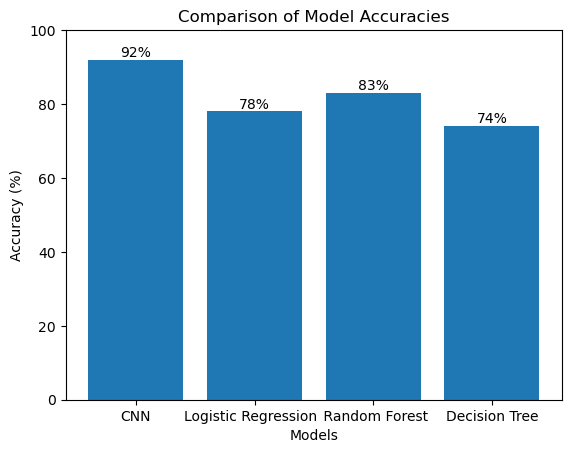

In [4]:
import matplotlib.pyplot as plt

models = ['CNN', 'Logistic Regression  ', ' Random Forest', 'Decision Tree']
accuracies = [92, 78, 83, 74]

fig, ax = plt.subplots()

bars = ax.bar(models, accuracies)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height}%', ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 100)

plt.show()
